# Lecture 7, Unsupervised Learning and Model Evaluation

## Ada Boost

Trained 50 weak learners
AdaBoost Metrics:
Accuracy: 0.9649
Precision: 0.9589
Recall: 0.9859
F1 Score: 0.9722


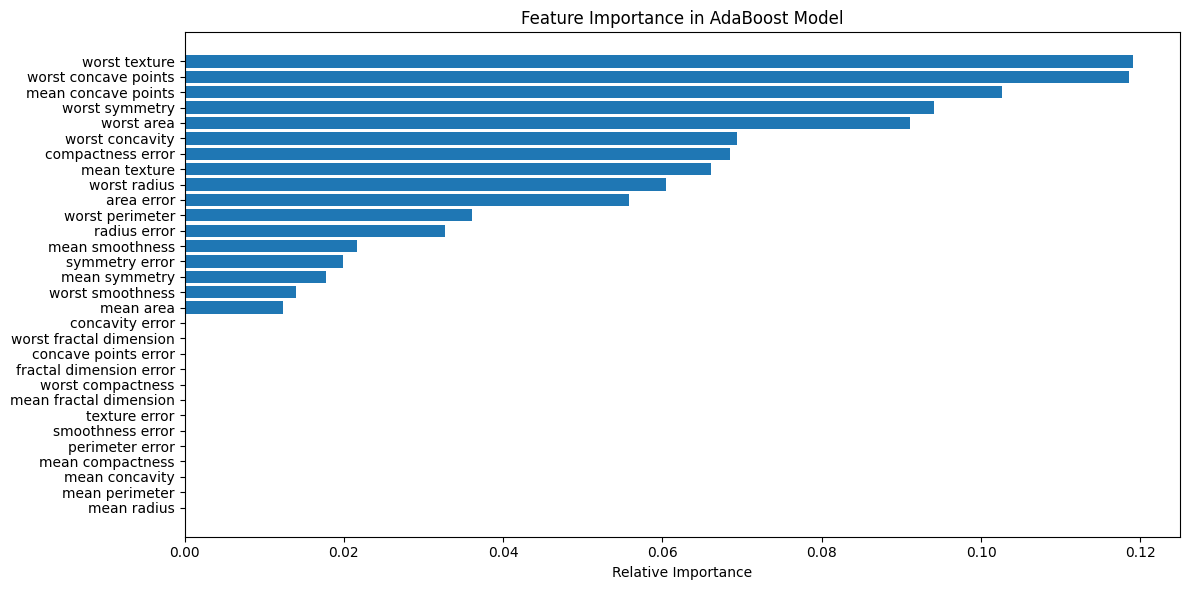

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

class AdaBoost:
    def __init__(self, n_estimators=50, learning_rate=1.0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.alphas = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        w = np.full(n_samples, (1 / n_samples))
        
        for _ in range(self.n_estimators):
            model = DecisionTreeClassifier(max_depth=1)  # Decision stump
            model.fit(X, y, sample_weight=w)
            
            predictions = model.predict(X)
            incorrect = predictions != y
            error = np.sum(w * incorrect) / np.sum(w)
            
            # Stop if error is 0 or 0.5 (no better than random guessing)
            if error == 0 or error >= 0.5:
                break
            
            alpha = self.learning_rate * 0.5 * np.log((1 - error) / error)
            
            w *= np.exp(alpha * incorrect)
            w /= np.sum(w)
            
            self.models.append(model)
            self.alphas.append(alpha)
        
        print(f"Trained {len(self.models)} weak learners")
    
    def predict(self, X):
        predictions = np.sum([
            alpha * model.predict(X) for alpha, model in zip(self.alphas, self.models)
        ], axis=0)
        return np.sign(predictions)

# Load and preprocess the dataset
data = load_breast_cancer()
X, y = data.data, data.target
y = np.where(y == 0, -1, 1)  # Convert labels to -1 and 1

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the model
adaboost = AdaBoost(n_estimators=50, learning_rate=1.0)
adaboost.fit(X_train, y_train)
predictions = adaboost.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"AdaBoost Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualize feature importance
feature_importance = np.zeros(X.shape[1])
for model, alpha in zip(adaboost.models, adaboost.alphas):
    feature_importance += alpha * model.feature_importances_

feature_importance /= sum(feature_importance)

# Sort features by importance
feature_names = np.array(data.feature_names)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_xlabel('Relative Importance')
ax.set_title('Feature Importance in AdaBoost Model')

plt.tight_layout()
plt.show()

## Gradient Boosting, regressor

Stopped after 51 iterations
Gradient Boosting Metrics:
Mean Squared Error: 0.3355
Mean Absolute Error: 0.4029
R2 Score: 0.7440


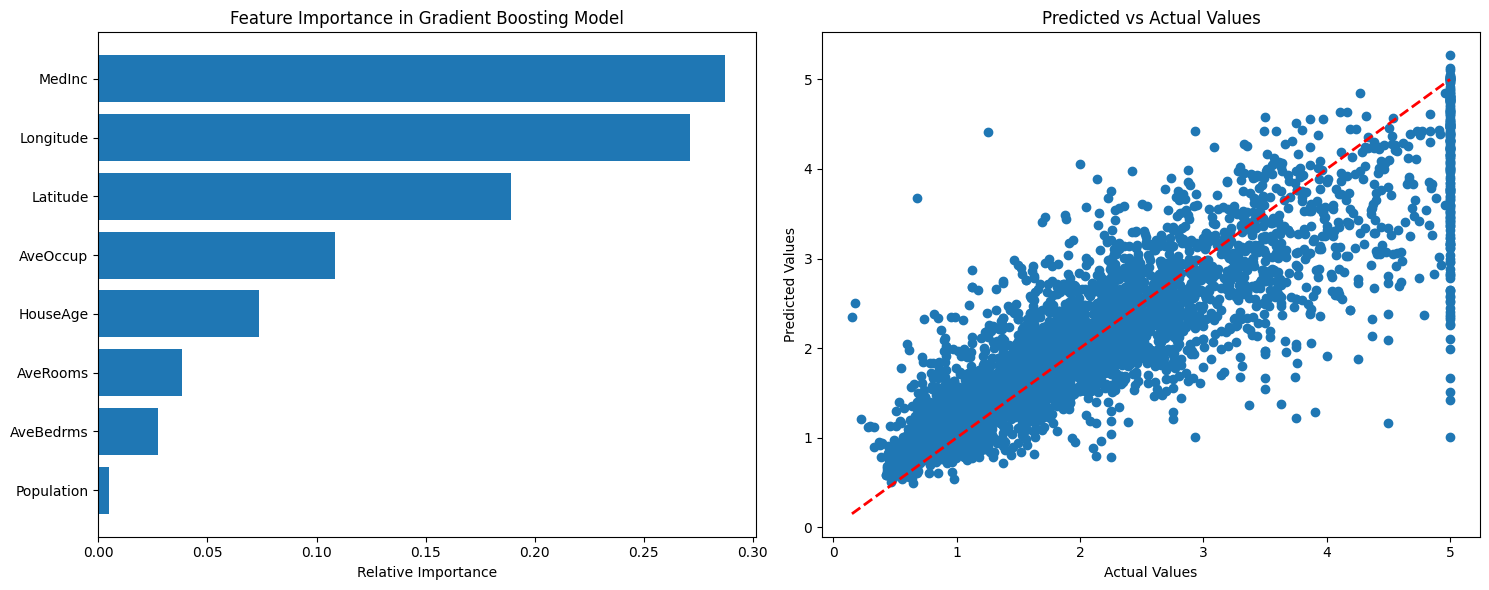

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

class GradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []

    def fit(self, X, y, tol=1e-4, max_iterations=None):
        self.models = []
        F = np.zeros(len(y))
        
        prev_mse = float('inf')
        for iteration in range(self.n_estimators):
            residuals = y - F
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            
            update = tree.predict(X)
            F += self.learning_rate * update
            
            self.models.append(tree)

            # Check stopping criteria
            mse = mean_squared_error(y, F)
            if max_iterations and iteration >= max_iterations:
                break
            if abs(prev_mse - mse) < tol:
                break
            prev_mse = mse

        print(f"Stopped after {len(self.models)} iterations")

    def predict(self, X):
        return np.sum([
            self.learning_rate * model.predict(X) for model in self.models
        ], axis=0)

# Load and preprocess the dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the model
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gb.fit(X_train, y_train, tol=1e-4, max_iterations=50)
predictions = gb.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Gradient Boosting Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# Visualize feature importance
feature_importance = np.zeros(X.shape[1])
for model in gb.models:
    feature_importance += model.feature_importances_

feature_importance /= len(gb.models)

# Sort features by importance
feature_names = np.array(data.feature_names)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Feature Importance Plot
ax1.barh(pos, feature_importance[sorted_idx], align='center')
ax1.set_yticks(pos)
ax1.set_yticklabels(feature_names[sorted_idx])
ax1.set_xlabel('Relative Importance')
ax1.set_title('Feature Importance in Gradient Boosting Model')

# Predicted vs Actual Plot
ax2.scatter(y_test, predictions)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title('Predicted vs Actual Values')

plt.tight_layout()
plt.show()

## Gradient Boosting, classifier

Stopped after 51 iterations
Gradient Boosting Classifier Metrics:
Accuracy: 0.9561
Precision: 0.9583
Recall: 0.9718
F1 Score: 0.9650
AUC-ROC: 0.9671


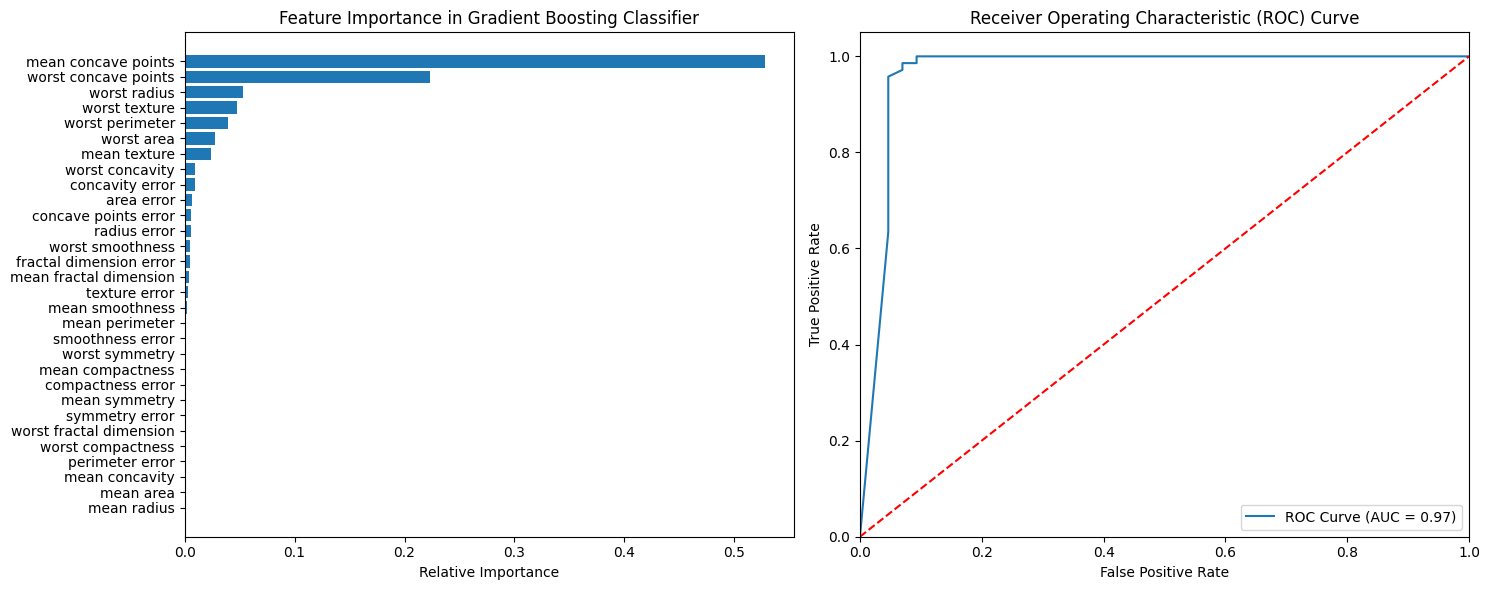

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from scipy.special import expit  # for sigmoid function

class GradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []

    def fit(self, X, y, tol=1e-4, max_iterations=None):
        self.models = []
        F = np.zeros(len(y))
        
        prev_loss = float('inf')
        for iteration in range(self.n_estimators):
            # Compute negative gradient
            prob = expit(F)
            negative_gradient = y - prob
            
            # Fit tree to negative gradient
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, negative_gradient)
            
            # Update F
            update = tree.predict(X)
            F += self.learning_rate * update
            
            self.models.append(tree)

            # Check stopping criteria
            loss = -np.mean(y * np.log(prob) + (1 - y) * np.log(1 - prob))  # Log loss
            if max_iterations and iteration >= max_iterations:
                break
            if abs(prev_loss - loss) < tol:
                break
            prev_loss = loss

        print(f"Stopped after {len(self.models)} iterations")

    def predict_proba(self, X):
        F = np.sum([
            self.learning_rate * model.predict(X) for model in self.models
        ], axis=0)
        return expit(F)

    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)

# Load and preprocess the dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the model
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
gb.fit(X_train, y_train, tol=1e-4, max_iterations=50)
predictions = gb.predict(X_test)
probabilities = gb.predict_proba(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
auc_roc = roc_auc_score(y_test, probabilities)

print(f"Gradient Boosting Classifier Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Visualize feature importance
feature_importance = np.zeros(X.shape[1])
for model in gb.models:
    feature_importance += model.feature_importances_

feature_importance /= len(gb.models)

# Sort features by importance
feature_names = np.array(data.feature_names)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Feature Importance Plot
ax1.barh(pos, feature_importance[sorted_idx], align='center')
ax1.set_yticks(pos)
ax1.set_yticklabels(feature_names[sorted_idx])
ax1.set_xlabel('Relative Importance')
ax1.set_title('Feature Importance in Gradient Boosting Classifier')

# ROC Curve Plot
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, probabilities)
ax2.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_roc:.2f})')
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()